# Generator modell

Ezen notebook egy kis jegyzetként szolgál a GAN hálózat Generátor modelljéhez.
A legegyszerűbb architektúrát kívánom bemutatni, a DCGAN generátorát, amely több későbbi modell alapjául szolgált. Remek kiinduló alap lehet. A modellt a keras _Sequential_ API segítségével állítottam össze.

In [1]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2DTranspose

from tensorflow import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np

2022-02-22 19:18:17.557221: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-22 19:18:17.557258: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Architektúra

A Generátor modell megalkotásakor a DCGAN cikkben felvetett modellt vettem alapul. Ezen architektúra természetesen a mai eredmények mellett egyszerűnek tűnhet elsőre, viszont a későbbi, fejlettebb architektúrákban többségében megfigyelhető, hogy erre építkeztek. Természetesen az architektúra egy igen egyszerű kiegészítést kínált az eredeti GAN hálózatra: konvolúciós rétegeket alkalmaz a rejtett rétegekben mind a Generátor, mind a Diszkriminátor esetében. A konvolúciós rétegek segítségével a képeken lévő összefüggő pixelek kapcsolatairól pontosabb reprezentációt kaphatunk, így képek generálásához is hasznos lehet a módszer. Az osztályozáshoz használt konvolúciós hálókkal ellentétben a Generátorban a kisebb felbontás felől haladunk a nagyobb felbontásig.

A generátor modellem első implementációjában _Dekonvolúciós_ rétegeket alkalmaztam, amelyet _Transzponált konvolúciós_ rétegnek is nevezhetünk. A Dekonvolúciós rétegek segítségével minden rejtett réteg kimenete egy nagyobb felbontású kép lesz, ellentétben a _konvolúció_ működésével. Tehát a hálónak jelen esetben meg kell tanulnia a rétegekben az optimális felbontás-növelést. Előre megadott paraméterek a filterek darabszáma, a kernel mérete, a strides(?) és a padding. Ha a padding-ot "same"-re és ha a strides paramétert 2x2-esnek választjuk, úgy a réteg kimenetén megjelenő kép felbontása kétszerese lesz a bemeneti oldalon megfigyelhető képnek. A rejtett rétegekben kezdetben ReLU aktivációs függvényt használtam, a neuronok kezdő értékeit a He inicializációs technikával állítottam be (Hands on könyv ajánlása alapján).

A tanításhoz célszerű a kép pixeleinek intenzitását normalizálni a [-1, 1] intervallumra. A Generátor is ebben az intervallumban fogja a képek pixeleit generálni a hiperbolikus tanges kimeneti aktivációs függvényéből adódóan. (tanh indoklás, sigmoid helyett..) A megjelenítéshez később természetesen denormalizálnunk kell a generált képek pixelértékeit a [0, 255] tartományra.

A Generátor modell bemenetként az előre definiált látens tér dimenziójával megegyező dimenziójú zajt kap. Majd ezen bemeneti zaj segítségével állítja össze a megfelelő kimeneti képet. A tanulás során tehát a látens tér tartományaihoz rendeli a tanult jellegzetességeket és a látens teret mintavételezve dekódolható a Generátor segítségével a ponthoz tartozó kép.

A bemeneti zaj egy Reshape rétegen megy keresztül, amelyben a látens tér dimenziószámát átformázza egy 1x1xLdim dimenziójú mátrixá. Ezen réteg kimenetével a későbbi dekonvolúciós rétegek már tudnak dolgozni.
Ezután az első dekonvolúciós rétegen megy át a kapott mátrix, amely 512 darab filtert tartalmaz, 4x4-es kernelméretekkle dolgozik és 'valid' paddingot használ. Az aktivációs függvénye ReLU a már említett He inicializálással. Ezen lépés arra szolgál, hogy a látens térből előállítson egy 4x4x512-es tensort, amely az első, legkisebb felbontású képünknek tekinthetjük ebben az esetben, ahol a színcsatornák száma 512 és a felbontása 4x4.

A Generátorban ezután 2x2-es stride értékeket használva a kívánt felbontásig dekonvolúciós rétegeken keresztül növekszik a felbontás. A kernel méretét a rétegekben egységesen 4x4-ra állítottam be, a paddig 'same' és a strides a már említett 2x2-es. Az aktivációs függvény szintén ReLU. A rétegekben haladva a filterek darabszáma pedig feleződik. A filterek optimális számára csupán csak empirikus eredményeket találtam. Az utolsó dekonvolúciós réteg 3 darab filterrel rendelkezik.

A kimeneti képnek olyan tulajdonságokkal kell rendelkeznie, mint a tanítómintában szeplő képeknek. Például ha a tanítóminta színes képekből áll, rgb színkeveréssel, vagyis három színcsatornával, úgy a Generátor kimenetén is ilyen képekre van szükségünk. Mivel az említett dekonvolúciós rétegek több mint 3 színcsatornával dolgoztak, a megjeleníthetőség miatt szükséges tehát az utolsó dekonvolúciós rétegben a 3 darab filter.
Végül a hiperbolikus tangens aktivációs függvény hatására az eredményeket a [-1, 1] intervallumba transzformálja.

In [2]:
# Látens tér dimenziószáma
latent_dim = 100

# Bemeneti zaj generálása
noise = random.normal([1, latent_dim])

2022-02-22 19:18:19.639644: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-22 19:18:19.639681: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-22 19:18:19.639712: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Inspiron-5558): /proc/driver/nvidia/version does not exist
2022-02-22 19:18:19.640099: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def add_upsampling_unit(model,
                        filters, kernel_size, strides, padding):
    model.add(
        Conv2DTranspose(
            filters=filters, kernel_size=kernel_size,
            strides=strides,
            padding=padding, activation="relu",
            kernel_initializer="he_normal"
        )
    )
    # model.add(BatchNormalization())

# Tesztelve, jól működik a macskás fejekre már így is
    
def make_generator_model(latent_dim):
    model = Sequential()
    model.add(Reshape((1, 1, 100), input_shape=[latent_dim]))

    add_upsampling_unit(model, 512, 4, (1, 1), 'valid')

    add_upsampling_unit(model, 256, 4, (2, 2), 'same')

    add_upsampling_unit(model, 128, 4, (2, 2), 'same')
    
    add_upsampling_unit(model, 64, 4, (2, 2), 'same')

    model.add(Conv2DTranspose(filters=3, kernel_size=4,
                              strides=(2, 2), padding='same'))
    model.add(Activation("tanh"))

    return model

In [4]:
random.set_seed(22)
model = make_generator_model(latent_dim)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         819712    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         2097408   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       524416    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 64)        131136    
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 64, 64, 3)         3075      
_________________________________________________________________
activation (Activation)      (None, 64, 64, 3)         0

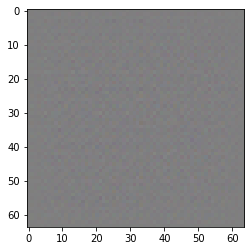

In [5]:
generated_images = model(noise, training=False)
gen_1 = generated_images[0].numpy()*127.5+127.5
plt.imshow((gen_1).astype("uint32"))

Ezen kezdetleges modell kimenetén a betanítás előtt a fenti képhez hasonlóakat figyelhetünk meg.
Ha ezt a Generátort hasznájuk a GAN halónkban, akkor a sakkmintás ismétlődő zajok a tanítás után is jelentkeznek a képeken és ez bizonyos esetekben nemkívánatos eredményekhez vezethet.

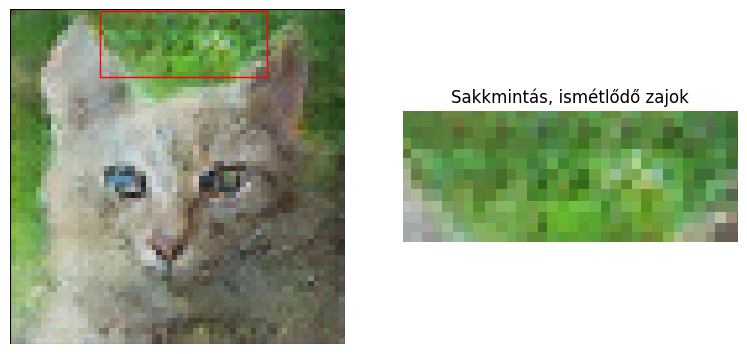

In [6]:
image = mpimg.imread('./images/chessboard.png')

xcoords = (80, 230)
ycoords = (60, 1)

fig, axes = plt.subplots(figsize=(8, 4), nrows=1, ncols=2, dpi=100)
plt.tight_layout()
# Create a Rectangle patch
rect = patches.Rectangle((xcoords[0], ycoords[1]),
                         xcoords[1]-xcoords[0], ycoords[0]-ycoords[1],
                         linewidth=1, edgecolor='r', facecolor='none')

axes[0].add_patch(rect)
axes[0].axis('off')
axes[0].imshow(image, interpolation='none')

axes[1].set_title("Sakkmintás, ismétlődő zajok")
axes[1].set_xlim(xcoords)
axes[1].set_ylim(ycoords)
axes[1].axis('off')

axes[1].imshow(image, interpolation='none')

# AnimalFaces-HQ datasetre betanított modell egy generált képe

A sakkmintázat kiküszöbölésére az alábbi cikkben a következő javaslatot találtam:
https://distill.pub/2016/deconv-checkerboard/
A cikkben a Dekonvolúciós rétegek helyett a Konvolúciós és UpSampling rétegeket ajánlották bilineáris interpolációval. Vagyis a felbontásnövelési feladatot elvették a dekonvolúciós rétegtől és egy tanítható-paraméter nélküli rétegre bízták a feladatot, aminek csak annyi a szerepe, hogy a felbontást növelje. Ezzel az ötlettel a sakkmintás zajt igen jól leredukálták a generált képeken. A tanítás előtti Generátor kimenetén is megfigyelhető, hogy a kép "lágyabb", kevésbé rendezettebb, mint az előző példában.

Viszont így önmagában nem volt szerencsém a modellt tanulásra bírnom és a BatchNormalization regularizációs rétegeket kellett beékelnem a modellbe. A technikát és a további alkalmazott regularizációs eljárásokat egy másik fejezeben foglalom majd össze.

(Próáblkozásaim során egyenlőre azt vettem észre, hogy ez a modell hajlamosabb a mode-collapse-ra, de biztosan valahol elrontottam, mert nem stimmelnek a dimenziók sem....) !!!Ezt még ki kell javítanom!!!

In [7]:
def add_upsampling_unit(model,
                        filters, kernel_size):
    model.add(
        Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding='same',
            activation="relu",
            kernel_initializer="he_normal"
        )
    )
    model.add(UpSampling2D())


def make_generator_model(latent_dim):
    model = Sequential()

    model.add(Reshape((1, 1, 100), input_shape=[latent_dim]))
    
    model.add(
        Conv2DTranspose(
            filters=512, kernel_size=4,
            strides=(1,1),
            padding='valid', activation="relu",
            kernel_initializer="he_normal"
        )
    )
    model.add(UpSampling2D())
    model.add(BatchNormalization())
    assert model.output_shape == (None, 8, 8, 512)
    add_upsampling_unit(model, 256, 3)
    model.add(BatchNormalization())
    assert model.output_shape == (None, 16, 16, 256)

    add_upsampling_unit(model, 128, 3)
    model.add(BatchNormalization())
    assert model.output_shape == (None, 32, 32, 128)

    add_upsampling_unit(model, 64, 3)
    assert model.output_shape == (None, 64, 64, 64)

    model.add(Conv2D(3, kernel_size=3, padding='same'))
    model.add(Activation("tanh"))
    assert model.output_shape == (None, 64, 64, 3)

    return model

In [8]:
random.set_seed(22)
model = make_generator_model(latent_dim)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 4, 4, 512)         819712    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 512)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 512)         2048      
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 256)         1179904   
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)      

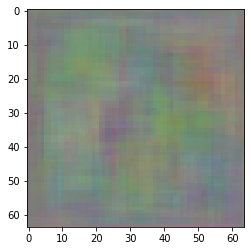

In [9]:
generated_images = model(noise, training=False)
gen_2 = generated_images[0].numpy()*127.5+127.5
plt.imshow((gen_2).astype("uint32"))

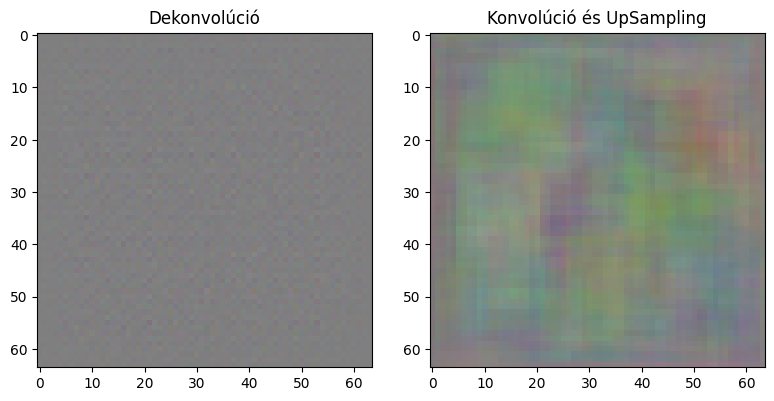

In [10]:
fig, axes = plt.subplots(figsize=(8, 4), nrows=1, ncols=2, dpi=100)
plt.tight_layout()
axes[0].set_title("Dekonvolúció")
axes[0].imshow((gen_1).astype("uint32"), interpolation='none')

axes[1].set_title("Konvolúció és UpSampling")
axes[1].imshow((gen_2).astype("uint32"), interpolation='none')

## Problémák
A modell természetesen bővíthető tetszőlegesen nagy felbontásig, a felbontást növelő rétegek számával. Viszont az architektúrával problémák léphetnek fel:
- A modell hajlamos az mode collapse-re, vagyis a tanulás során jelentkező összeomlásra.

A mode collapse jelenség akkor figyelhető meg, amikor a Generátor a látens tér bármely pontjára egyetlen egy (vagy ritkán kétféle) képet generál. Egyes cikkekben az összeomlásig tanítják a felvázolt modelleket és az összeomlás előtti pillanati állapotokra ugranak vissza a használathoz (BigGAN csinált ilyet, meg még más is, de meg kell keresnem.). Az mode collepse elkerülésére és a hálózat kiegészítésére igen hasznos javaslatok jelentek meg. Ezeket külön-külön is kifejtem... (!)

- A konvolúciós rétegek működéséből adódóan csupán lokális pixel-környezetekre képes összefüggő részeket generálni a modell.

Ez a működés alacsony felbontásnál még nem okoz gondot, viszont a felbontás növelésével a modell nem tudja felismerni és megtanulni a tanítóminta képein megfigyelhető távoli összefüggő tulajdonságokat. Így a generált képek részletezettsége alacsony lesz, gyakran blobokat figyelhetünk meg csupán, különböző textúrákkal. A globális összefüggőségre több javaslat is érkezett a DCGAN megjelenése óta...

- A modellnek nincsen információja a különféle osztályokról, csupán a képek rendezettlen halmazán tanul, így magától kell megtanulnia a különféle osztályokba tartozó objektumok jellegzetességeit.

Az általánosítás szempontjából ez előnyös is lehet, viszont ha merőben különböző osztályokra szeretnénk betanítani a modellt, akkor az úgynevezett _class conditoning_ nélkül ezt igen nehezen tudnánk megvalósítani. (A technikának még utána kell néznem, hogy pontosan hogyan leht kondicionálni...)